In [1]:
#Look for a model to be trained to perform semantic segmentation
#Dataset + related guide: https://idiotdeveloper.com/unet-implementation-in-tensorflow-using-keras-api/
#                         https://www.kaggle.com/datasets/b9d4e32be2f57c2901fc9c5cd5f6633be7075f4b32d73348a6d5db245f2c1934

#Semantic segmentation using U-Net: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
path = '/Users/salvo/BackgroundRemover/people_segmentation/masks/ache-adult-depression-expression-41253.png'

For this example image we extract the "MASK" which should contain all zero values and ones corresponding to the mask

In [4]:
img = cv2.imread(path)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img)
#plt.show()
print(np.max(img))
print(np.min(img))
print(img.shape)

1
0
(800, 533, 3)


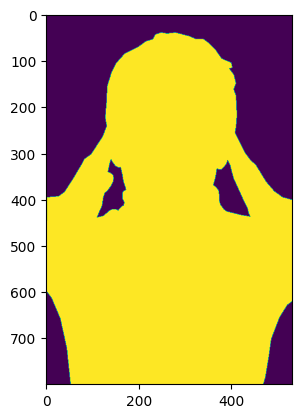

In [5]:
#_, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.show()

In [6]:
path = '/Users/salvo/BackgroundRemover/people_segmentation/images/ache-adult-depression-expression-41253.jpg'

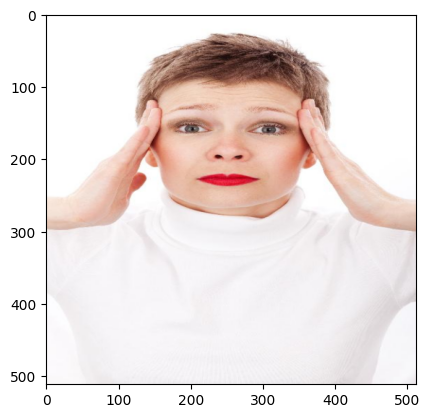

In [7]:
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dim = (512, 512)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

plt.imshow(resized)
plt.show()

Here we define the structure of the U-Net architecture in Keras/TensorFlow

In [8]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

/Users/salvo/miniforge3/envs/jupyter1/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/salvo/miniforge3/envs/jupyter1/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/salvo/miniforge3/envs/jupyter1/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/salvo/miniforge3/envs/jupyter1/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/Users/salvo/miniforge3/envs/jupyter1/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ["dlopen(/Users/salvo/miniforge3/envs/jupy

In [9]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [10]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [11]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [12]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [13]:
input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

2023-01-22 20:16:15.473891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-22 20:16:15.474150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                           

                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 1024  4719616     ['max_pooling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 32, 32, 1024  4096       ['conv2d_8[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 

                                                                                                  
 activation_15 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_15[0][0]'] 
                                8)                                                                
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 512, 512, 64  32832      ['activation_15[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 512, 512, 12  0           ['conv2d_transpose_3[0][0]',     
                                8)                                'activation_1[0][0]']           
                                                                                                  
 conv2d_16

Here we load the lists of names identifying images belonging to train, trainval and val sets:

In [14]:
import os

In [15]:
with open("/Users/salvo/BackgroundRemover/people_segmentation/segmentation/train.txt", "r") as f:
    train_list = f.read().split("\n")
with open("/Users/salvo/BackgroundRemover/people_segmentation/segmentation/trainval.txt", "r") as f:
    trainval_list = f.read().split("\n")
with open("/Users/salvo/BackgroundRemover/people_segmentation/segmentation/val.txt", "r") as f:
    val_list = f.read().split("\n")  

Here we define a data generator which reads images from filesystem dynamically

In [16]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, image_path, mask_path, to_fit=True, batch_size=8, dim=(512, 512), n_channels=3, n_classes=1, shuffle=True):
        self.list_IDs = list_IDs
        self.labels = labels
        self.image_path = image_path
        self.mask_path = mask_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X = self._generate_X(list_IDs_temp)
        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = self._load_color_image(self.image_path + self.labels[ID] + ".jpg")
        return X

    def _generate_y(self, list_IDs_temp):
        y = np.empty((self.batch_size, *self.dim), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            y[i,] = self._load_bw_image(self.mask_path + self.labels[ID] + ".png")
        return y

    def _load_color_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.dim, interpolation = cv2.INTER_AREA)
        img = img / 255
        return img
    
    def _load_bw_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, self.dim, interpolation = cv2.INTER_AREA)
        img = img / 255
        return img

In [17]:
train_idx = [i for i in range(len(train_list))]
val_idx = [i for i in range(len(trainval_list))]

In [18]:
import tensorflow as tf
image_path = '/Users/salvo/BackgroundRemover/people_segmentation/images/'
mask_path = '/Users/salvo/BackgroundRemover/people_segmentation/masks/'

training_generator = DataGenerator(train_idx, train_list, image_path, mask_path)
validation_generator = DataGenerator(val_idx, trainval_list, image_path, mask_path)

# Design model
#model = Sequential()
#[...] # Architecture
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryCrossentropy()])

#model.fit(training_generator, validation_data=validation_generator)

In [19]:
model.fit(training_generator, validation_data=validation_generator)

2023-01-22 20:16:16.184805: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-22 20:16:16.945164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 64/638 [==>...........................] - ETA: 33:47 - loss: 0.2061 - binary_crossentropy: 0.2061

KeyboardInterrupt: 

In [ ]:
a = training_generator[0][0][2]
plt.imshow(a)
plt.show()